# Práctica 5
### Redes neuronales convolutivas

In [54]:
from scipy.io import arff
import torchvision.transforms as transforms
import torchvision
import torch

In [55]:
train_set = torchvision.datasets.FashionMNIST(root = '../datos/FashionMNIST', download = True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST(root = '../datos/FashionMNIST', download=True, train=False, transform = transforms.Compose([transforms.ToTensor()]))

In [56]:
bandeja = 32
train_loader = torch.utils.data.DataLoader(train_set,shuffle=True, batch_size=bandeja)
train_accuracy_loader = torch.utils.data.DataLoader(train_set, batch_size=6000)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1000)

In [57]:
from torch.utils.data import Dataset

In [58]:
class Flatten_Dataset(Dataset):
 def __init__(self, images, labels):
    self.images = images
    self.labels = labels
 def __len__(self):
    return self.images.shape[0]
 def __getitem__(self, idx):
    return self.images[idx], self.labels[idx]

In [59]:
train_images = torch.zeros((len(train_loader.dataset), 28*28), dtype=torch.float32)
train_labels = torch.empty(len(train_loader.dataset), dtype=torch.long)
for i, (image, label) in enumerate(train_loader.dataset):
	train_images[i] = torch.flatten(image)
	train_labels[i] = label

In [60]:
import torch.nn as nn
import torch.optim as optim
import tqdm

In [61]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)

        self.relu = nn.LeakyReLU()

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(in_features=4*4*128,out_features=128)
        self.out = nn.Linear(in_features=128,out_features=10)


    def forward(self,x):
        #first CNN layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        #second CNN layer
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)

        #mlp hidden layer
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)

        #output layer
        x = self.out(x)
        return x

In [62]:
model = Network()

xx, yy = next(iter(train_loader))
x1 = model.pool(model.relu(model.conv2(model.relu(model.conv1(xx)))))
x2 = model.pool(model.relu(model.conv4(model.relu(model.conv3(x1)))))
x2.shape

torch.Size([32, 128, 4, 4])

In [63]:
from torchsummary import summary

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
         LeakyReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
         LeakyReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 64, 10, 10]          18,496
         LeakyReLU-7           [-1, 64, 10, 10]               0
            Conv2d-8            [-1, 128, 8, 8]          73,856
         LeakyReLU-9            [-1, 128, 8, 8]               0
        MaxPool2d-10            [-1, 128, 4, 4]               0
           Linear-11                  [-1, 128]         262,272
        LeakyReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 360,714
Trainable params:

In [65]:
X_train, y_train = next(iter(train_accuracy_loader))
X_test, y_test = next(iter(test_loader))

In [68]:
import numpy as np

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
learning_rate = []

epochs = 20
for i in range(epochs):
   print("Epoch: ", i)
   model.train(True)
   for images, targets in tqdm.tqdm(train_loader):
      images, targets = images.to(device), targets.to(device)  # Move to device
      # making predictions
      y_pred = model(images)
      # calculating loss
      loss = criterion(y_pred, targets.long())
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

   with torch.no_grad():
      aciertos = 0
      muestras = 0
      perdidas = 0.0
      for X_train, y_train in train_accuracy_loader:
         X_train, y_train = X_train.to(device), y_train  # Move to device
         y_train_pred = model(X_train)
         aciertos += np.sum((y_train == y_train_pred.cpu().argmax(dim=1)).numpy())
         muestras += X_train.shape[0]
         perdidas += criterion(y_train_pred.cpu(), y_train.long()).numpy()

   train_accuracy.append(aciertos/muestras)
   train_loss.append(perdidas)

   print('Train Loss: {0:.5f}'.format(train_loss[-1]), '\tTrain Accuracy: {0:.5f}'.format(train_accuracy[-1]))

with torch.no_grad():
   aciertos = 0
   muestras = 0
   perdidas = 0.0
   for X_test, y_test in test_loader:
      X_test, y_test = X_test.to(device), y_test.cpu()  # Move to device
      y_test_pred = model(X_test)

      aciertos += np.sum((y_test == y_test_pred.cpu().argmax(dim=1)).numpy())
      muestras += X_test.shape[0]
      perdidas += criterion(y_test_pred.cpu(), y_test.long()).numpy()

test_accuracy.append(aciertos/muestras)
test_loss.append(perdidas)

learning_rate.append(optimizer.param_groups[0]['lr'])
print(' Val Loss: {0:.5f}'.format(test_loss[-1]), '\t Test Accuracy: {0:.5f}'.format(test_accuracy[-1]), "\tLearning Rate:", learning_rate[-1])





Epoch:  0


  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [00:10<00:00, 180.86it/s]


Train Loss: 4.40923 	Train Accuracy: 0.83960
Epoch:  1


100%|██████████| 1875/1875 [00:10<00:00, 174.06it/s]


Train Loss: 4.25679 	Train Accuracy: 0.84782
Epoch:  2


100%|██████████| 1875/1875 [00:09<00:00, 194.69it/s]


Train Loss: 4.05404 	Train Accuracy: 0.85438
Epoch:  3


100%|██████████| 1875/1875 [00:09<00:00, 190.84it/s]


Train Loss: 3.98484 	Train Accuracy: 0.85745
Epoch:  4


100%|██████████| 1875/1875 [00:08<00:00, 220.78it/s]


Train Loss: 3.86353 	Train Accuracy: 0.86267
Epoch:  5


100%|██████████| 1875/1875 [00:09<00:00, 194.89it/s]


Train Loss: 3.80301 	Train Accuracy: 0.86312
Epoch:  6


100%|██████████| 1875/1875 [00:09<00:00, 195.32it/s]


Train Loss: 3.74913 	Train Accuracy: 0.86548
Epoch:  7


100%|██████████| 1875/1875 [00:09<00:00, 189.24it/s]


Train Loss: 3.68526 	Train Accuracy: 0.86740
Epoch:  8


100%|██████████| 1875/1875 [00:09<00:00, 189.19it/s]


Train Loss: 3.63638 	Train Accuracy: 0.86952
Epoch:  9


100%|██████████| 1875/1875 [00:09<00:00, 197.32it/s]


Train Loss: 3.57531 	Train Accuracy: 0.87170
Epoch:  10


100%|██████████| 1875/1875 [00:09<00:00, 204.34it/s]


Train Loss: 3.53692 	Train Accuracy: 0.87337
Epoch:  11


100%|██████████| 1875/1875 [00:09<00:00, 198.06it/s]


Train Loss: 3.51100 	Train Accuracy: 0.87388
Epoch:  12


100%|██████████| 1875/1875 [00:10<00:00, 187.17it/s]


Train Loss: 3.47434 	Train Accuracy: 0.87562
Epoch:  13


100%|██████████| 1875/1875 [00:11<00:00, 166.12it/s]


Train Loss: 3.46503 	Train Accuracy: 0.87522
Epoch:  14


100%|██████████| 1875/1875 [00:09<00:00, 189.49it/s]


Train Loss: 3.40731 	Train Accuracy: 0.87885
Epoch:  15


100%|██████████| 1875/1875 [00:10<00:00, 181.08it/s]


Train Loss: 3.39830 	Train Accuracy: 0.87840
Epoch:  16


100%|██████████| 1875/1875 [00:09<00:00, 194.72it/s]


Train Loss: 3.36256 	Train Accuracy: 0.87968
Epoch:  17


100%|██████████| 1875/1875 [00:09<00:00, 190.28it/s]


Train Loss: 3.35416 	Train Accuracy: 0.88015
Epoch:  18


100%|██████████| 1875/1875 [00:10<00:00, 183.73it/s]


Train Loss: 3.32349 	Train Accuracy: 0.88063
Epoch:  19


100%|██████████| 1875/1875 [00:11<00:00, 170.35it/s]


Train Loss: 3.30734 	Train Accuracy: 0.88175
 Val Loss: 3.64674 	 Test Accuracy: 0.86990 	Learning Rate: 0.001


CNN2d(in=1, out=16, kernel=3)

28x28x1 ---CNN1x16--> 16x26x26 ---CNN16x32--> 32x24x24 ---POOL2x2--> 32x12x12 ---CNN32X64--> 64x10x10 ---CNN64x128--> 128x8x8 ---POOL2x2---> 128x4x4

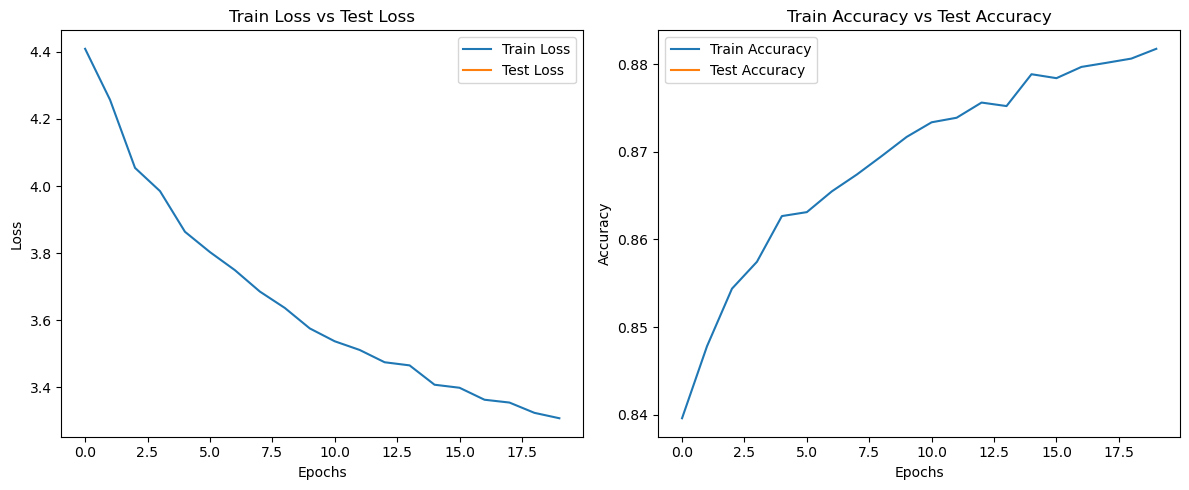

In [71]:
import matplotlib.pyplot as plt

# Plotting Train Loss and Test Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()

# Plotting Train Accuracy and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()